# German Speed Limit Sign Recognition with Tensorflow and Keras

## Take this as a starting point
## Work in this notebook and add workshop steps here

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Local Installation requires libs Scikit Learn, TensorFlow, and Keras to be installed already

In [3]:
import sklearn
# should at least be 0.18
sklearn.__version__

'0.18.1'

In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# should at least be 1.0
tf.__version__

'1.0.0'

In [5]:
import keras as keras
# should at least be 1.2 and use TensorFlow backend
keras.__version__

Using TensorFlow backend.


'2.0.3'

## Analyse and Prepare Image Data

In [6]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [7]:
# Load datasets.
ROOT_PATH = "../../data"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [8]:
len(set(labels)), len(images)

(6, 379)

In [9]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        plt.imshow(image)
    plt.show()

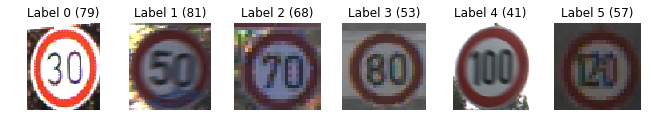

In [10]:
display_images_and_labels(images, labels)

In [11]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (61, 51, 3), min: 0, max: 255
shape: (55, 56, 3), min: 0, max: 255
shape: (80, 77, 3), min: 0, max: 255
shape: (41, 40, 3), min: 34, max: 255
shape: (32, 32, 3), min: 8, max: 255


In [12]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [13]:
for image in images64[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (64, 64, 3), min: 0.025211109834559136, max: 1.0
shape: (64, 64, 3), min: 0.0004308363970588852, max: 1.0
shape: (64, 64, 3), min: 0.011462162990196529, max: 1.0
shape: (64, 64, 3), min: 0.13649854473039216, max: 1.0
shape: (64, 64, 3), min: 0.05343137254901961, max: 1.0


In [14]:
y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))

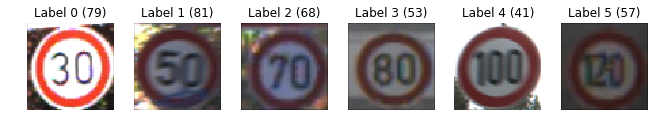

In [15]:
display_images_and_labels(images64, labels)

In [16]:
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [17]:
# https://keras.io/getting-started/functional-api-guide/
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

tower_1 = Convolution2D(16, (1, 1), padding='same', activation='relu')(inputs)
tower_1 = Convolution2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Convolution2D(16, (1, 1), padding='same', activation='relu')(inputs)
tower_2 = Convolution2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
tower_3 = Convolution2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

x = Flatten()(output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.50)(x)

predictions = Dense(6, activation='softmax')(x)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=predictions)

In [18]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [20]:
from datetime import tzinfo, timedelta, datetime

In [39]:
print(datetime.utcnow().isoformat())
model.fit(X_train, y_train, nb_epoch=40, batch_size=32)
print(datetime.utcnow().isoformat())

2017-04-17T10:03:10.494794
Epoch 1/5
303/303 [==============================] - 52s - loss: 0.6494 - acc: 0.7954     
Epoch 2/5
303/303 [==============================] - 53s - loss: 0.4892 - acc: 0.8317     

In [40]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [41]:
# that is a tad hard to read, just choose the category

ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([2, 0, 0, 1, 1, 1, 0, 1, 3, 2])

In [42]:
# now make the prediction for the sample inputs
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)

In [43]:
# softmax predictions would be even harder to read, again just choose the hightst category

predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([2, 0, 2, 1, 1, 1, 2, 1, 2, 2])

In [44]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

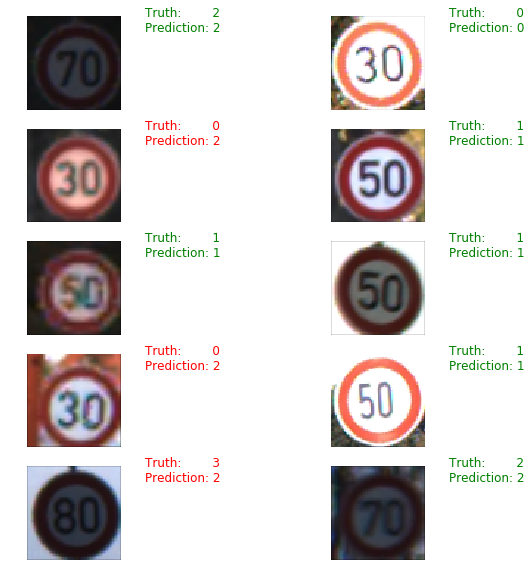

In [45]:
display_prediction(sample_images, ground_truth, predicted_categories)

In [46]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 8s     


(0.1024735009807958, 0.98679867986798675)

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

76/76 [==============================] - 2s     


(0.69021818041801453, 0.80263158208445495)

In [48]:
model.save('models/conv_inception_no_dropout.h5')